In [1]:
# Importamos Librerias Necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from math import sqrt
from scipy.stats import probplot
from sklearn.model_selection import ParameterGrid
import seaborn as sns


In [2]:
#Cargar la función para llegar a los CSV divididos
def load_split(seed):
    X_train = pd.read_csv(f'X_train_{seed}.csv')
    X_test = pd.read_csv(f'X_test_{seed}.csv')
    y_train = pd.read_csv(f'y_train_{seed}.csv')
    y_test = pd.read_csv(f'y_test_{seed}.csv')
    
    return X_train, X_test, y_train, y_test


Cross-validated MSE: 0.3675026810476669
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters: {'depth': 5, 'iterations': 300, 'learning_rate': 0.01}


C:\Users\HP\AppData\Local\Temp\ipykernel_20604\3948777919.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)


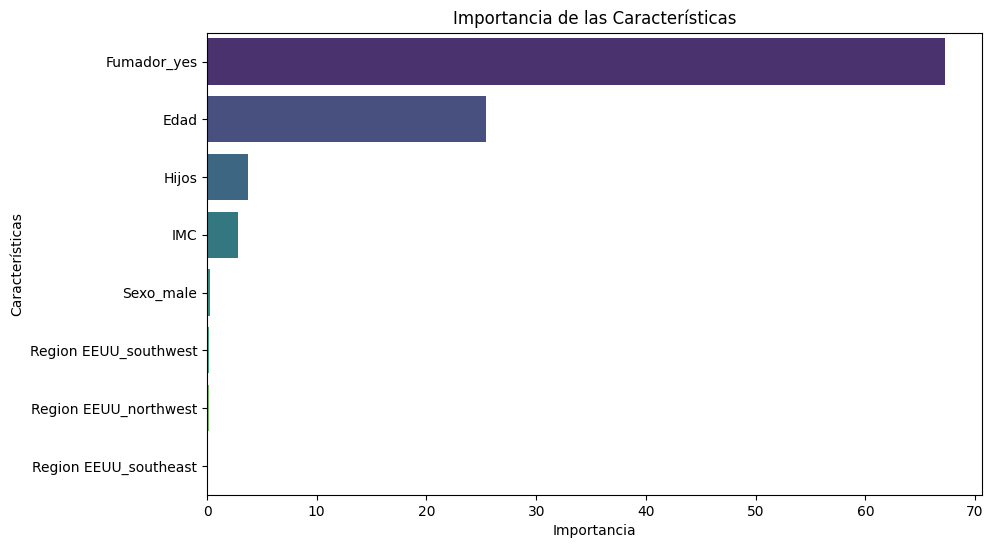

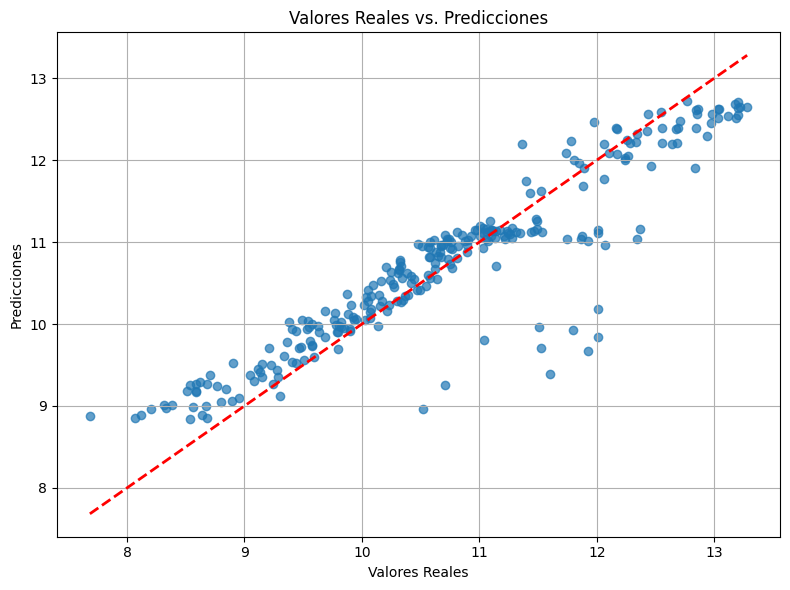

MAE: 0.3489410438381261
MSE: 0.26174091905812485
RMSE: 0.5116062148353212
R2 Score: 0.8362817703726393
RMSLE: 0.04448087516280829
MAPE: 3.284712594181723


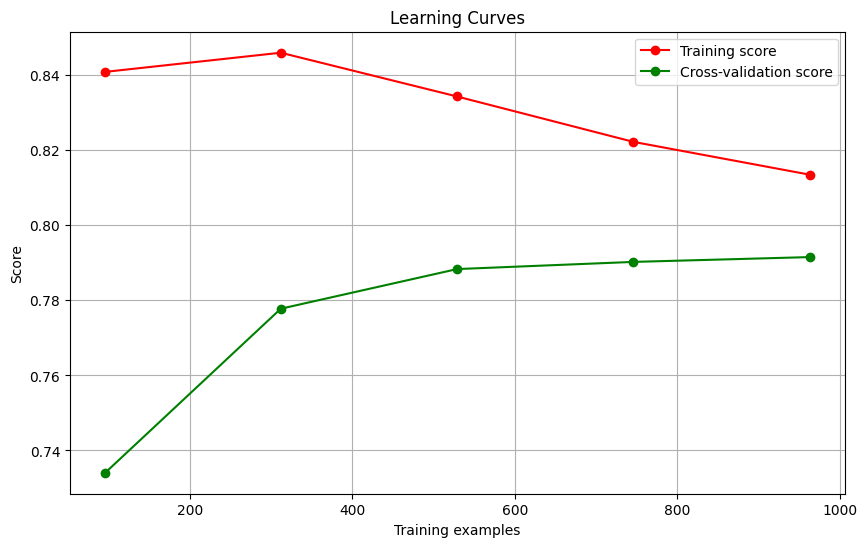

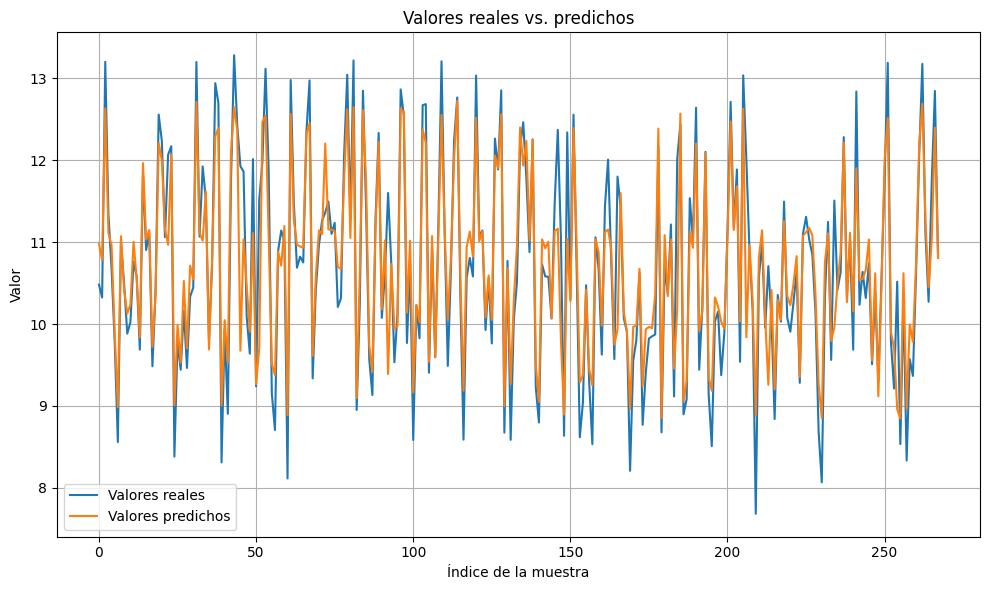

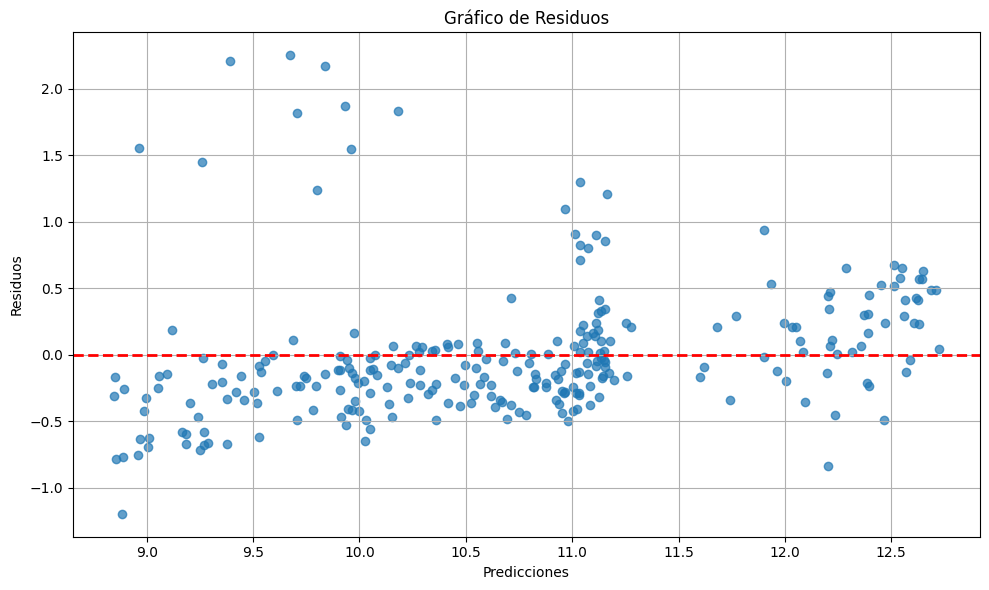

In [5]:

# Cargar una división específica (por ejemplo, la primera división)
X_train, X_test, y_train, y_test = load_split(0)

# Aplicar One-Hot Encoding a las variables categóricas
categorical_cols = ['Sexo', 'Fumador', 'Region EEUU']
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Ajustar y transformar las variables categóricas de X_train
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Transformar las variables categóricas de X_test
X_test_encoded = encoder.transform(X_test[categorical_cols])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenar las variables codificadas con las variables numéricas
X_train = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True), X_test_encoded_df], axis=1)

# Convertir y_train e y_test a series de pandas para asegurar que no haya problemas de tipo
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# CatBoost Regression
# Iniciamos el modelo
model = CatBoostRegressor(random_state=42, silent=True)

# Ajustamos el modelo a los datos
model.fit(X_train, y_train)

# Realizamos la validación cruzada con 10-fold
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(f"Cross-validated MSE: {-np.mean(scores)}")

# Optimización de los Hiperparámetros
# Definimos los valores para iterar y elegir los mejores parámetros
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 4, 5]
}

# Iniciamos la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)

# Ajustamos a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtenemos los mejores parámetros
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Actualizamos el modelo con los parámetros encontrados
model = grid_search.best_estimator_

# Características más importantes
# Obtenemos la importancia de cada variable
importances = model.feature_importances_

# Creamos un conjunto de datos para las características y su importancia
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Ordenamos por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleccionamos la misma paleta de colores utilizada anteriormente
n_colores = len(feature_importances)
colores = sns.color_palette('viridis', n_colors=n_colores)

# Graficamos las características y su importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Realizamos las predicciones
y_pred = model.predict(X_test)

# Asegurarnos de que y_test y y_pred sean del tipo float
y_test = y_test.astype(float)
y_pred = y_pred.astype(float)

# Gráfico de dispersión de los valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculamos MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Calculamos RMSLE (Root Mean Squared Logarithmic Error)
if (y_test >= 0).all() and (y_pred >= 0).all():
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print("RMSLE:", rmsle)
else:
    print("RMSLE: cannot be calculated because some values are negative")

# Calculamos MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = mape(y_test, y_pred)
print("MAPE:", mape_score)

# Graficamos la curva de aprendizaje (learning curve)
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Gráfico de línea de los valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores reales")
plt.plot(y_pred, label="Valores predichos")
plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Valores reales vs. predichos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular residuos
residuos = y_test - y_pred

# Graficar los residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()


Cross-validated MSE: 0.33462937226392964
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters: {'depth': 5, 'iterations': 100, 'learning_rate': 0.1}


C:\Users\HP\AppData\Local\Temp\ipykernel_20604\3639618353.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)


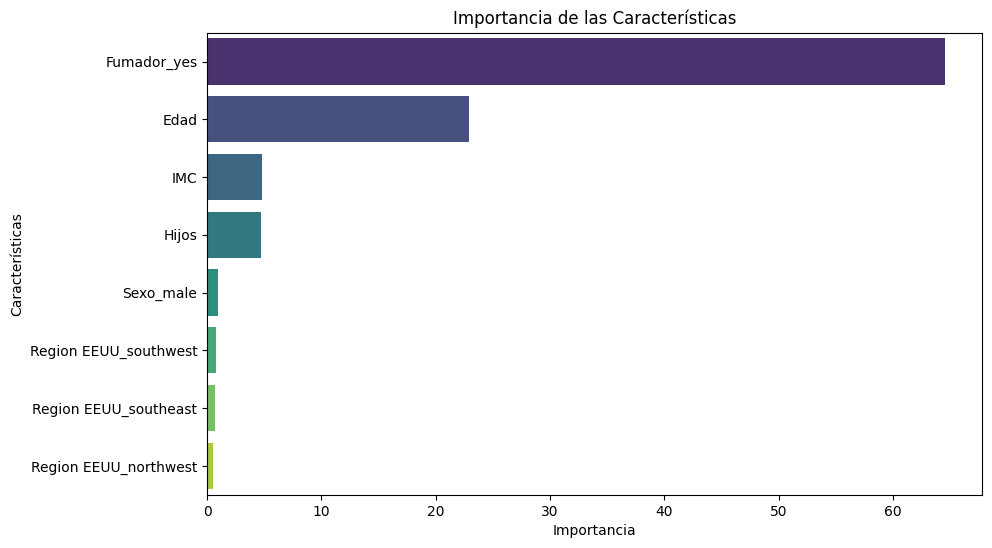

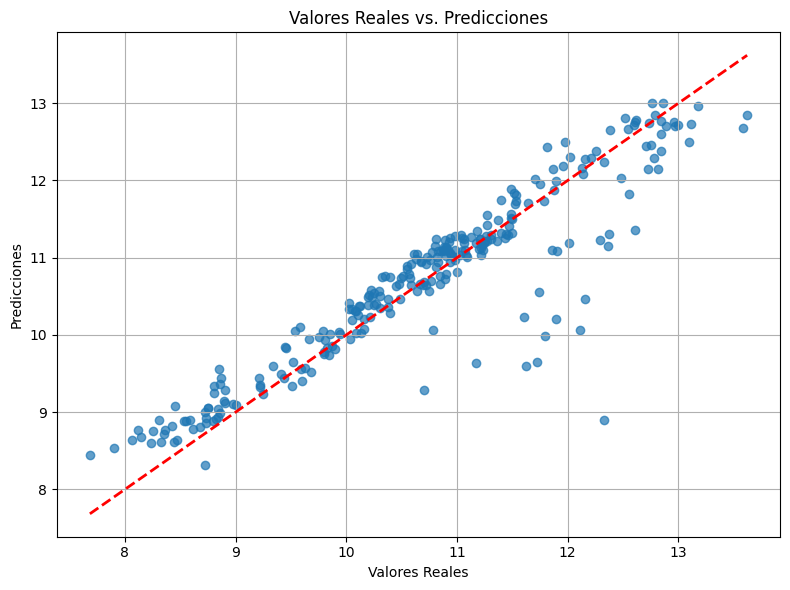

MAE: 0.30948399868944165
MSE: 0.2542267137949224
RMSE: 0.5042089981296669
R2 Score: 0.8460975354120386
RMSLE: 0.043277214764114474
MAPE: 2.878904409996805


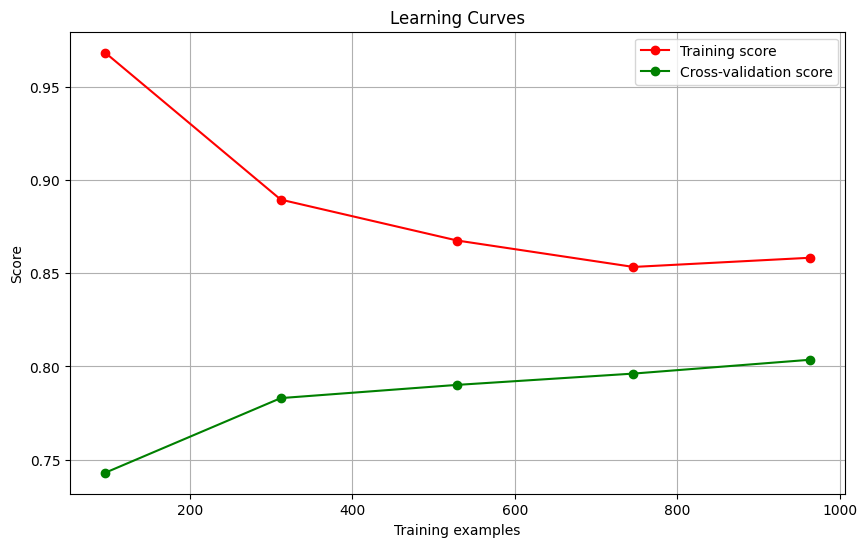

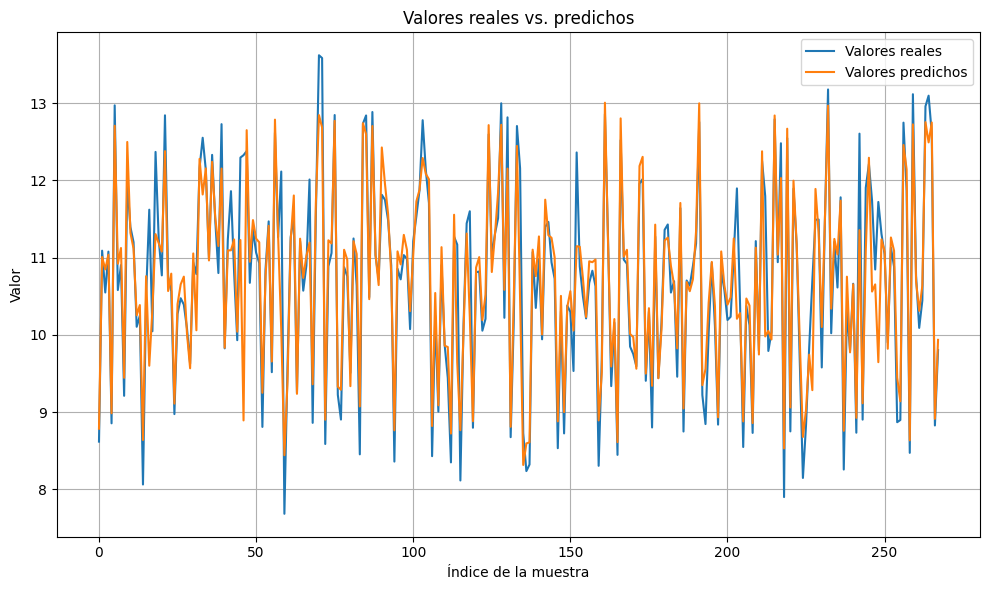

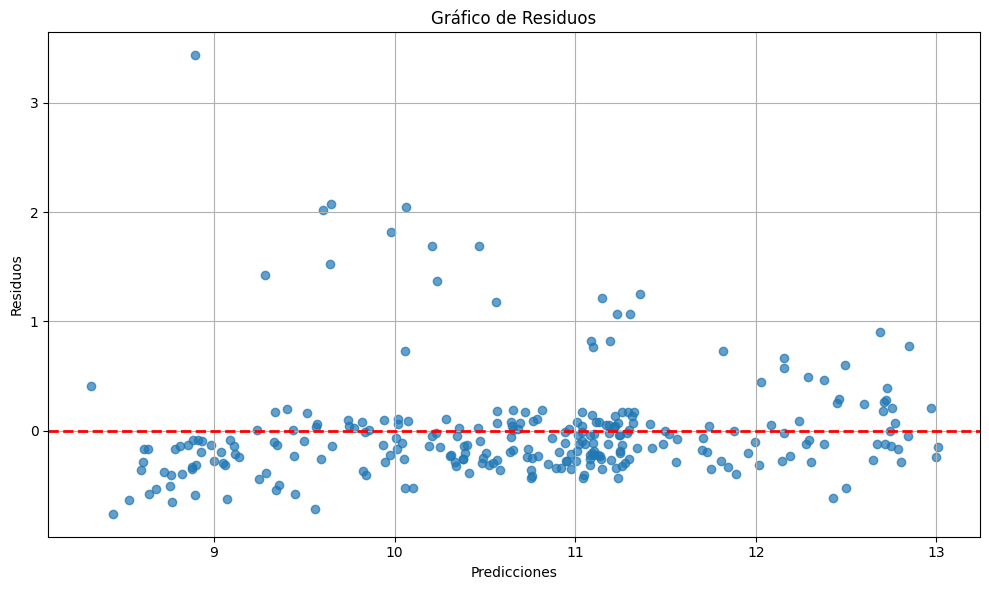

In [6]:

# Cargar una división específica (por ejemplo, la primera división)
X_train, X_test, y_train, y_test = load_split(1)

# Aplicar One-Hot Encoding a las variables categóricas
categorical_cols = ['Sexo', 'Fumador', 'Region EEUU']
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Ajustar y transformar las variables categóricas de X_train
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Transformar las variables categóricas de X_test
X_test_encoded = encoder.transform(X_test[categorical_cols])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenar las variables codificadas con las variables numéricas
X_train = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True), X_test_encoded_df], axis=1)

# Convertir y_train e y_test a series de pandas para asegurar que no haya problemas de tipo
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# CatBoost Regression
# Iniciamos el modelo
model = CatBoostRegressor(random_state=42, silent=True)

# Ajustamos el modelo a los datos
model.fit(X_train, y_train)

# Realizamos la validación cruzada con 10-fold
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(f"Cross-validated MSE: {-np.mean(scores)}")

# Optimización de los Hiperparámetros
# Definimos los valores para iterar y elegir los mejores parámetros
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 4, 5]
}

# Iniciamos la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)

# Ajustamos a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtenemos los mejores parámetros
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Actualizamos el modelo con los parámetros encontrados
model = grid_search.best_estimator_

# Características más importantes
# Obtenemos la importancia de cada variable
importances = model.feature_importances_

# Creamos un conjunto de datos para las características y su importancia
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Ordenamos por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleccionamos la misma paleta de colores utilizada anteriormente
n_colores = len(feature_importances)
colores = sns.color_palette('viridis', n_colors=n_colores)

# Graficamos las características y su importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Realizamos las predicciones
y_pred = model.predict(X_test)

# Asegurarnos de que y_test y y_pred sean del tipo float
y_test = y_test.astype(float)
y_pred = y_pred.astype(float)

# Gráfico de dispersión de los valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculamos MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Calculamos RMSLE (Root Mean Squared Logarithmic Error)
if (y_test >= 0).all() and (y_pred >= 0).all():
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print("RMSLE:", rmsle)
else:
    print("RMSLE: cannot be calculated because some values are negative")

# Calculamos MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = mape(y_test, y_pred)
print("MAPE:", mape_score)

# Graficamos la curva de aprendizaje (learning curve)
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Gráfico de línea de los valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores reales")
plt.plot(y_pred, label="Valores predichos")
plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Valores reales vs. predichos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular residuos
residuos = y_test - y_pred

# Graficar los residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()


Cross-validated MSE: 0.3425767086742548
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters: {'depth': 5, 'iterations': 100, 'learning_rate': 0.1}


C:\Users\HP\AppData\Local\Temp\ipykernel_20604\1484884936.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)


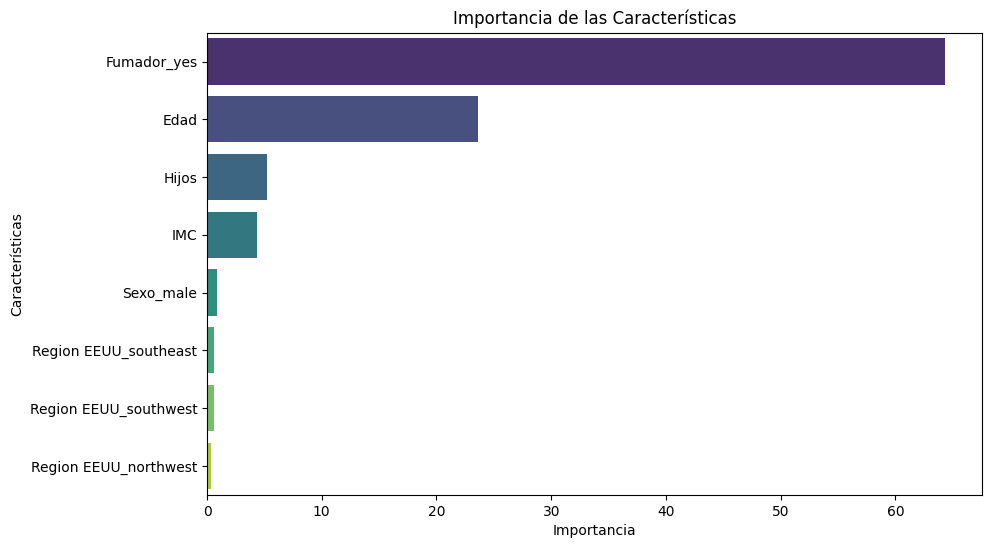

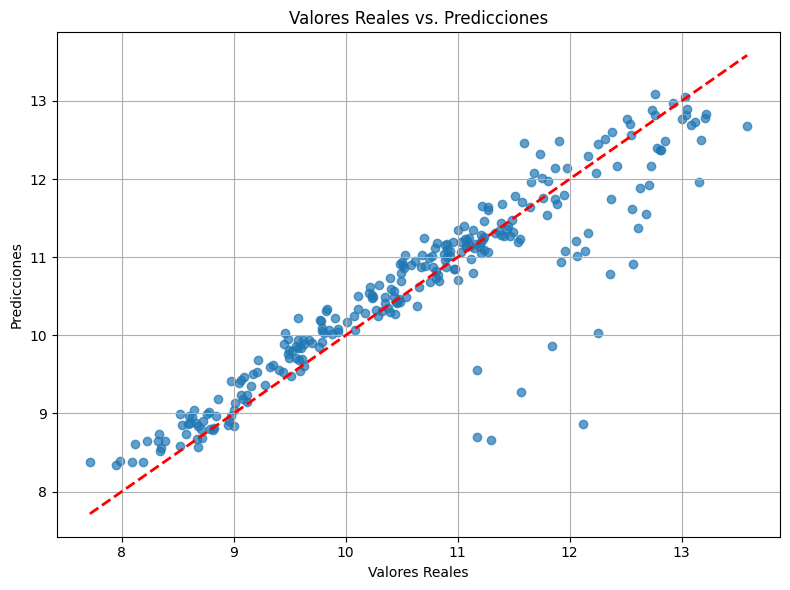

MAE: 0.32455829732439784
MSE: 0.28453062123475076
RMSE: 0.5334141179559749
R2 Score: 0.8412313425389107
RMSLE: 0.04578495408315526
MAPE: 2.9927204537656333


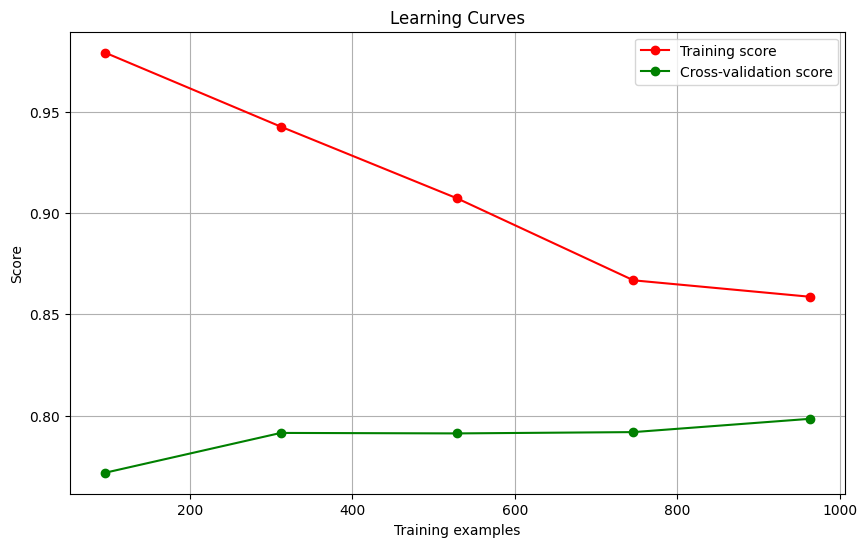

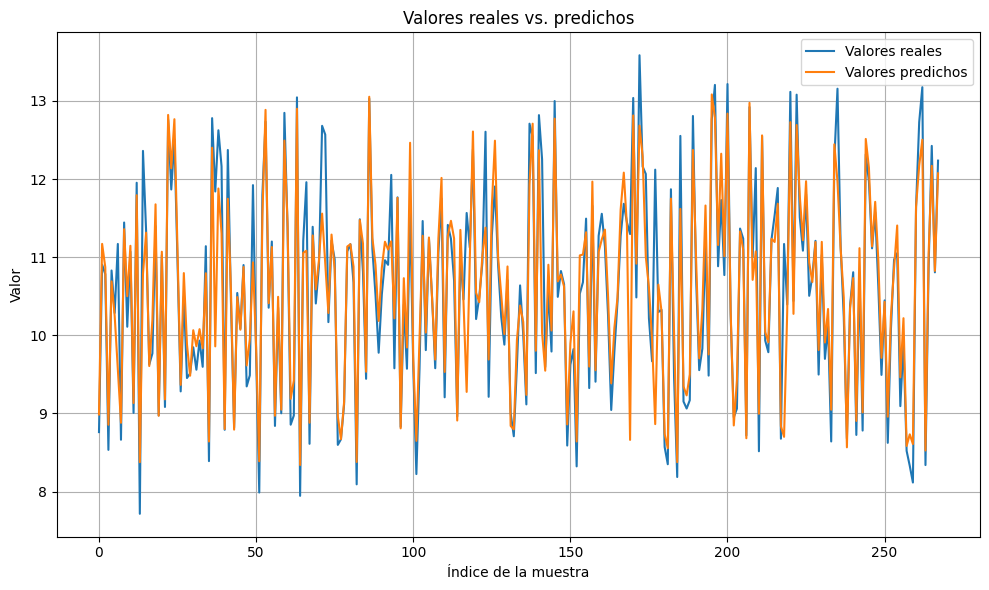

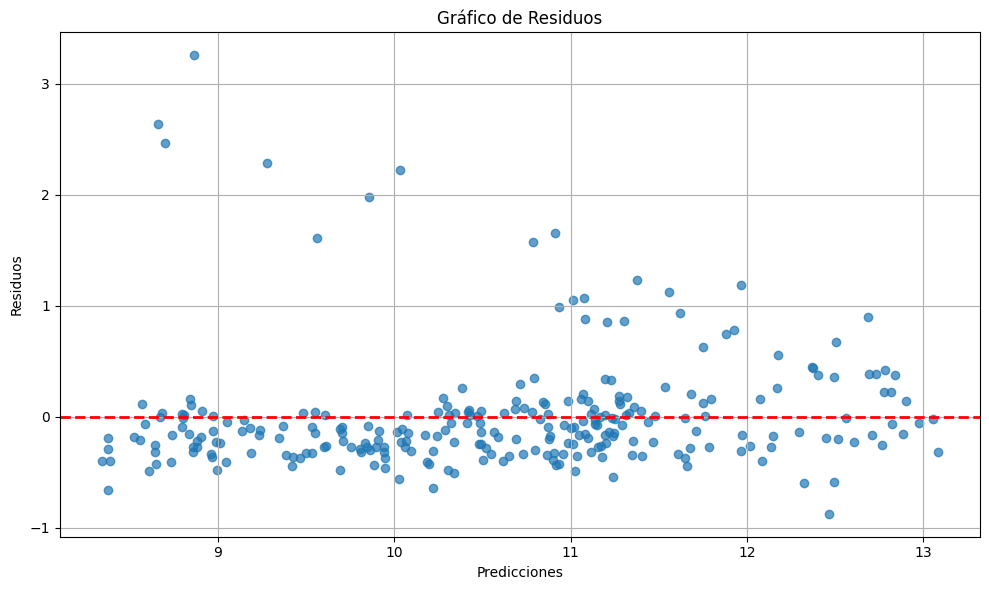

In [7]:

# Cargar una división específica (por ejemplo, la primera división)
X_train, X_test, y_train, y_test = load_split(2)

# Aplicar One-Hot Encoding a las variables categóricas
categorical_cols = ['Sexo', 'Fumador', 'Region EEUU']
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Ajustar y transformar las variables categóricas de X_train
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Transformar las variables categóricas de X_test
X_test_encoded = encoder.transform(X_test[categorical_cols])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenar las variables codificadas con las variables numéricas
X_train = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True), X_test_encoded_df], axis=1)

# Convertir y_train e y_test a series de pandas para asegurar que no haya problemas de tipo
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# CatBoost Regression
# Iniciamos el modelo
model = CatBoostRegressor(random_state=42, silent=True)

# Ajustamos el modelo a los datos
model.fit(X_train, y_train)

# Realizamos la validación cruzada con 10-fold
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(f"Cross-validated MSE: {-np.mean(scores)}")

# Optimización de los Hiperparámetros
# Definimos los valores para iterar y elegir los mejores parámetros
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 4, 5]
}

# Iniciamos la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)

# Ajustamos a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtenemos los mejores parámetros
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Actualizamos el modelo con los parámetros encontrados
model = grid_search.best_estimator_

# Características más importantes
# Obtenemos la importancia de cada variable
importances = model.feature_importances_

# Creamos un conjunto de datos para las características y su importancia
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Ordenamos por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleccionamos la misma paleta de colores utilizada anteriormente
n_colores = len(feature_importances)
colores = sns.color_palette('viridis', n_colors=n_colores)

# Graficamos las características y su importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Realizamos las predicciones
y_pred = model.predict(X_test)

# Asegurarnos de que y_test y y_pred sean del tipo float
y_test = y_test.astype(float)
y_pred = y_pred.astype(float)

# Gráfico de dispersión de los valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculamos MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Calculamos RMSLE (Root Mean Squared Logarithmic Error)
if (y_test >= 0).all() and (y_pred >= 0).all():
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print("RMSLE:", rmsle)
else:
    print("RMSLE: cannot be calculated because some values are negative")

# Calculamos MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = mape(y_test, y_pred)
print("MAPE:", mape_score)

# Graficamos la curva de aprendizaje (learning curve)
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Gráfico de línea de los valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores reales")
plt.plot(y_pred, label="Valores predichos")
plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Valores reales vs. predichos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular residuos
residuos = y_test - y_pred

# Graficar los residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()


Cross-validated MSE: 0.31515857979782014
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}


C:\Users\HP\AppData\Local\Temp\ipykernel_20604\3008980608.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)


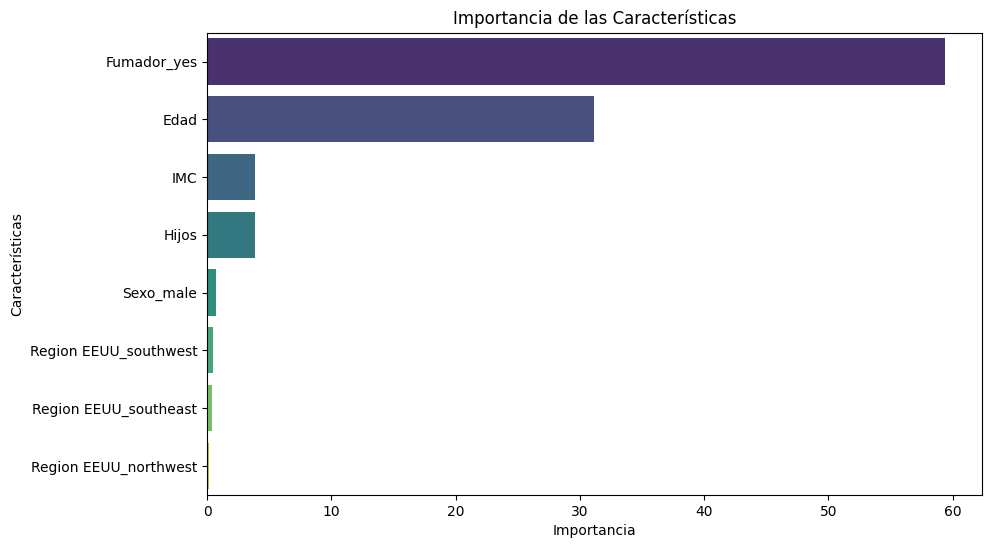

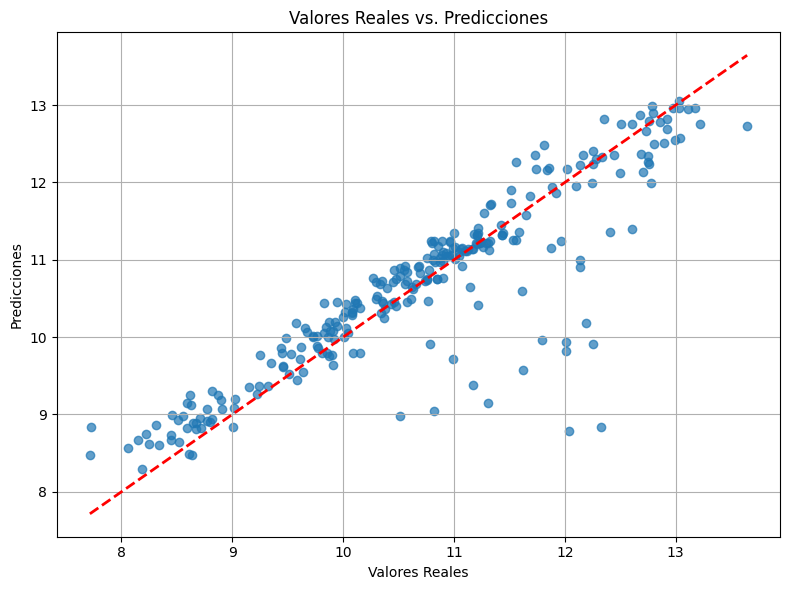

MAE: 0.34858746719153433
MSE: 0.35153758299242366
RMSE: 0.5929060490435425
R2 Score: 0.7877312393967846
RMSLE: 0.051452791322147994
MAPE: 3.232286865088846


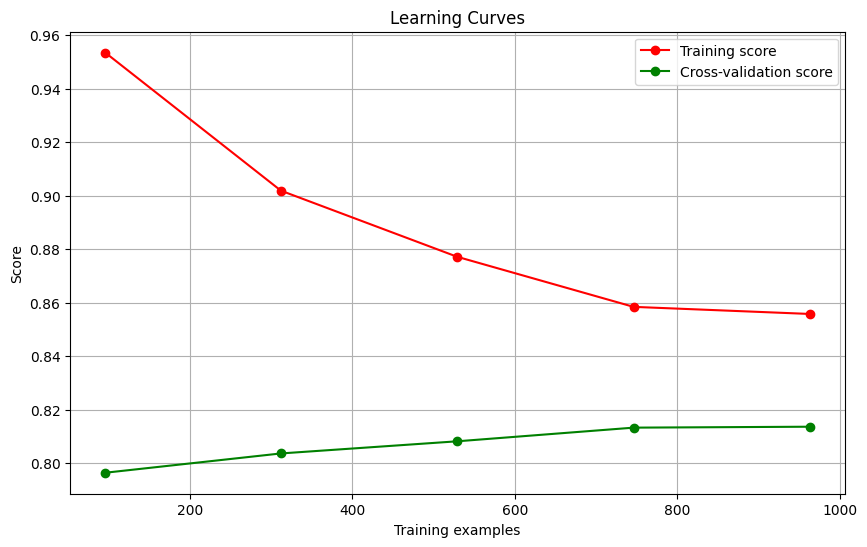

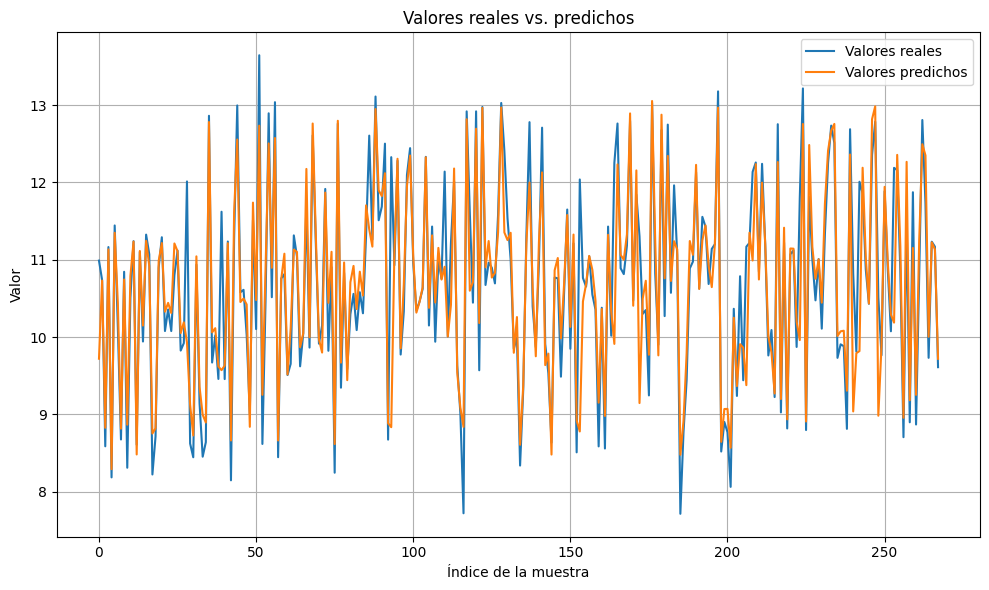

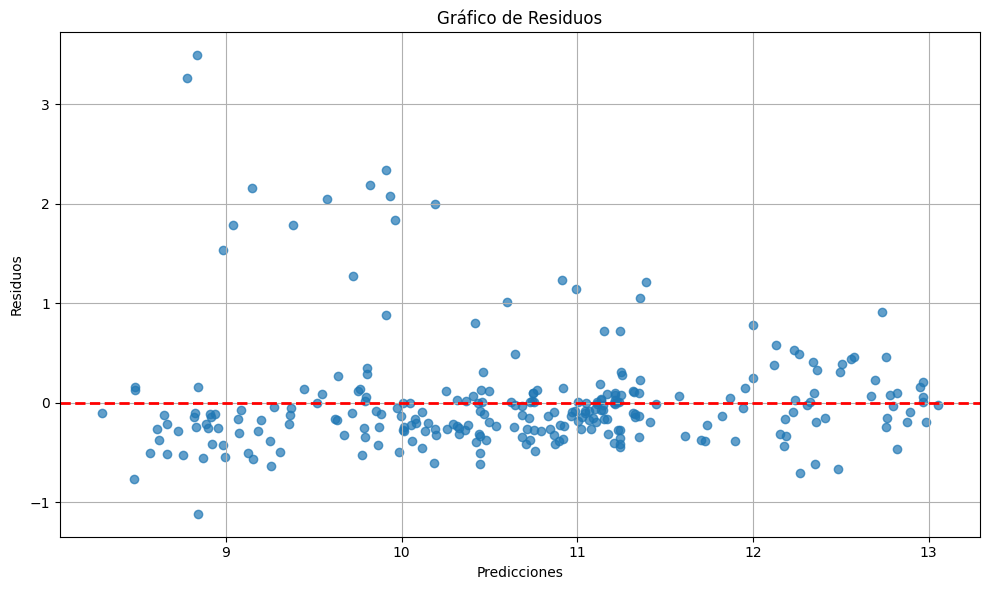

In [8]:

# Cargar una división específica (por ejemplo, la primera división)
X_train, X_test, y_train, y_test = load_split(3)

# Aplicar One-Hot Encoding a las variables categóricas
categorical_cols = ['Sexo', 'Fumador', 'Region EEUU']
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Ajustar y transformar las variables categóricas de X_train
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Transformar las variables categóricas de X_test
X_test_encoded = encoder.transform(X_test[categorical_cols])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenar las variables codificadas con las variables numéricas
X_train = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True), X_test_encoded_df], axis=1)

# Convertir y_train e y_test a series de pandas para asegurar que no haya problemas de tipo
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# CatBoost Regression
# Iniciamos el modelo
model = CatBoostRegressor(random_state=42, silent=True)

# Ajustamos el modelo a los datos
model.fit(X_train, y_train)

# Realizamos la validación cruzada con 10-fold
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(f"Cross-validated MSE: {-np.mean(scores)}")

# Optimización de los Hiperparámetros
# Definimos los valores para iterar y elegir los mejores parámetros
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 4, 5]
}

# Iniciamos la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)

# Ajustamos a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtenemos los mejores parámetros
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Actualizamos el modelo con los parámetros encontrados
model = grid_search.best_estimator_

# Características más importantes
# Obtenemos la importancia de cada variable
importances = model.feature_importances_

# Creamos un conjunto de datos para las características y su importancia
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Ordenamos por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleccionamos la misma paleta de colores utilizada anteriormente
n_colores = len(feature_importances)
colores = sns.color_palette('viridis', n_colors=n_colores)

# Graficamos las características y su importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Realizamos las predicciones
y_pred = model.predict(X_test)

# Asegurarnos de que y_test y y_pred sean del tipo float
y_test = y_test.astype(float)
y_pred = y_pred.astype(float)

# Gráfico de dispersión de los valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculamos MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Calculamos RMSLE (Root Mean Squared Logarithmic Error)
if (y_test >= 0).all() and (y_pred >= 0).all():
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print("RMSLE:", rmsle)
else:
    print("RMSLE: cannot be calculated because some values are negative")

# Calculamos MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = mape(y_test, y_pred)
print("MAPE:", mape_score)

# Graficamos la curva de aprendizaje (learning curve)
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Gráfico de línea de los valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores reales")
plt.plot(y_pred, label="Valores predichos")
plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Valores reales vs. predichos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular residuos
residuos = y_test - y_pred

# Graficar los residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()


Cross-validated MSE: 0.30705535604266543
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}


C:\Users\HP\AppData\Local\Temp\ipykernel_20604\3175513296.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)


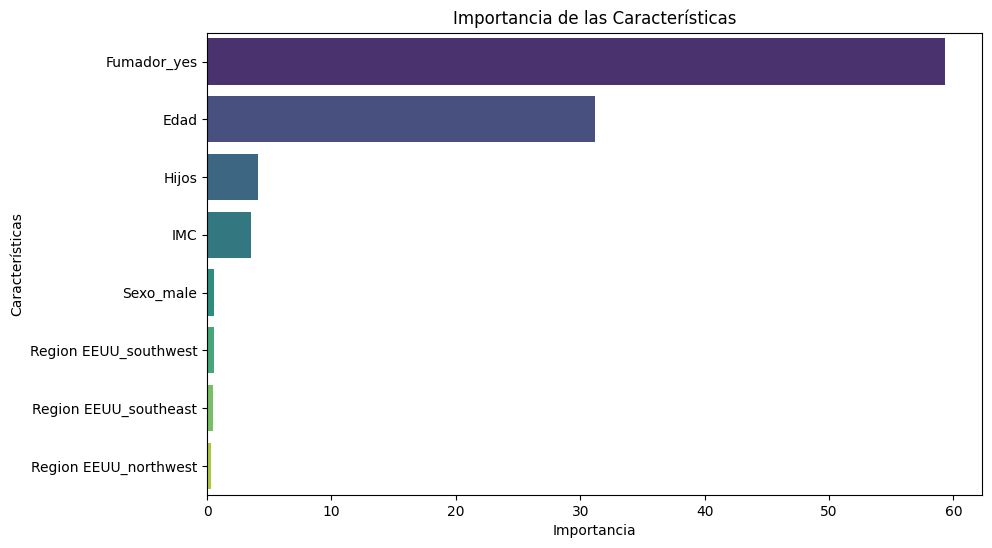

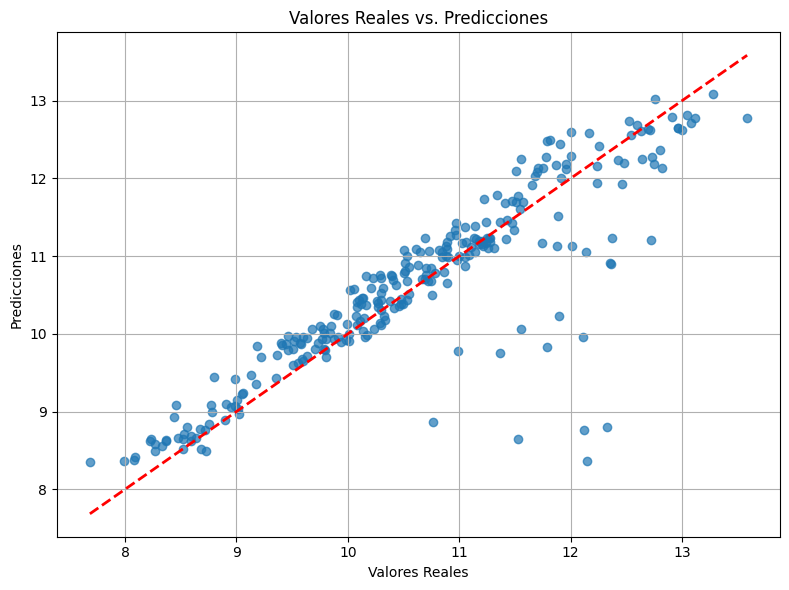

MAE: 0.34769675809675704
MSE: 0.37141745060244474
RMSE: 0.609440276485272
R2 Score: 0.7649385273946342
RMSLE: 0.05287310423244335
MAPE: 3.190352692238285


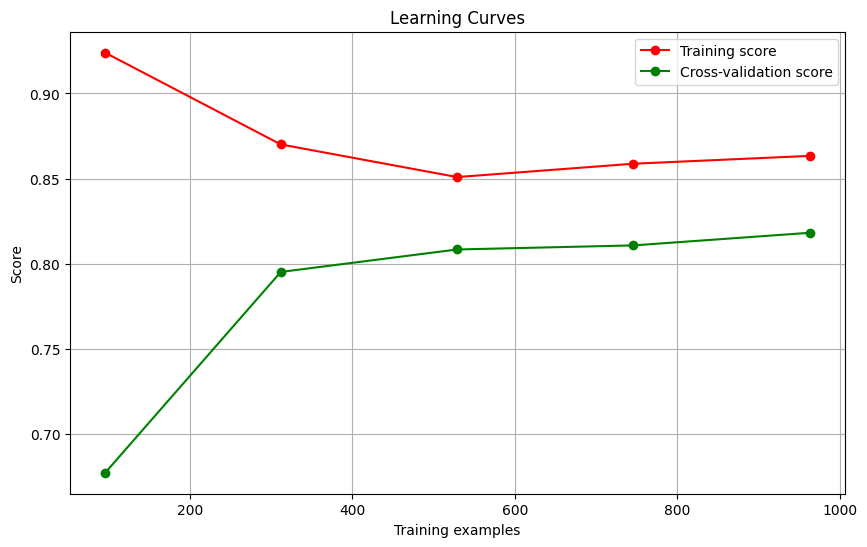

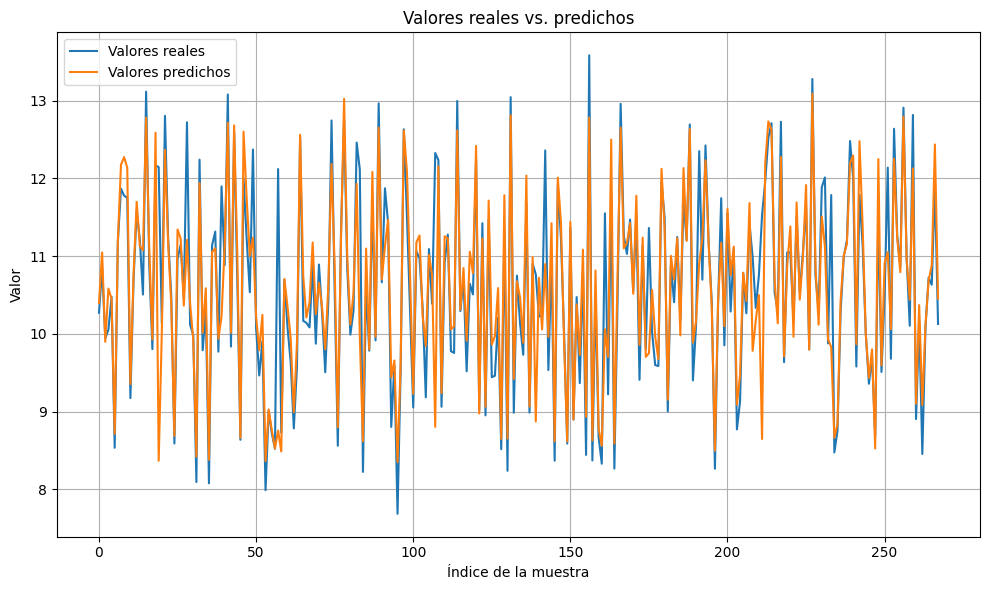

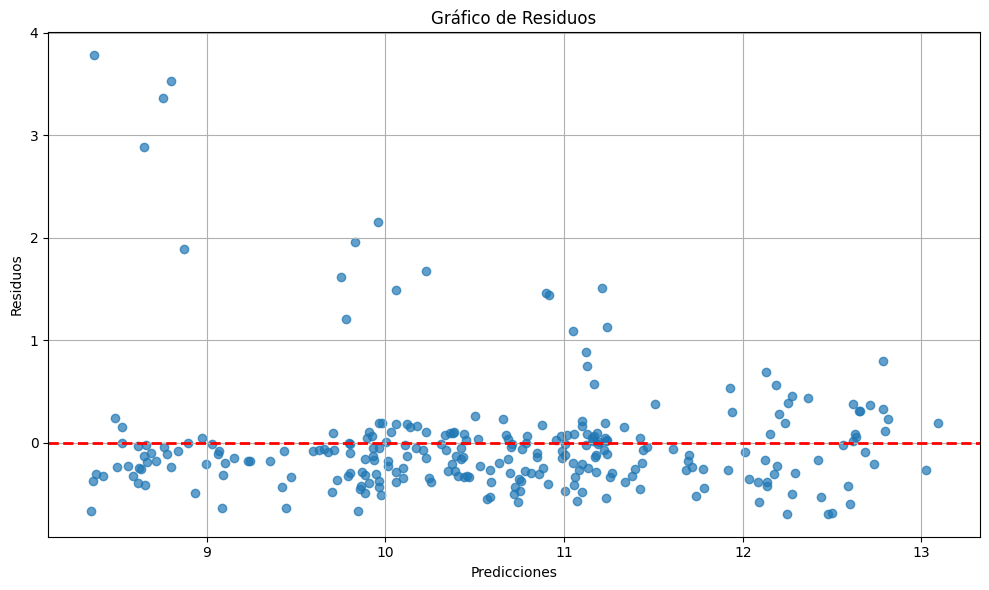

In [9]:

# Cargar una división específica (por ejemplo, la primera división)
X_train, X_test, y_train, y_test = load_split(4)

# Aplicar One-Hot Encoding a las variables categóricas
categorical_cols = ['Sexo', 'Fumador', 'Region EEUU']
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Ajustar y transformar las variables categóricas de X_train
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Transformar las variables categóricas de X_test
X_test_encoded = encoder.transform(X_test[categorical_cols])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenar las variables codificadas con las variables numéricas
X_train = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True), X_test_encoded_df], axis=1)

# Convertir y_train e y_test a series de pandas para asegurar que no haya problemas de tipo
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# CatBoost Regression
# Iniciamos el modelo
model = CatBoostRegressor(random_state=42, silent=True)

# Ajustamos el modelo a los datos
model.fit(X_train, y_train)

# Realizamos la validación cruzada con 10-fold
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(f"Cross-validated MSE: {-np.mean(scores)}")

# Optimización de los Hiperparámetros
# Definimos los valores para iterar y elegir los mejores parámetros
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 4, 5]
}

# Iniciamos la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)

# Ajustamos a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtenemos los mejores parámetros
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Actualizamos el modelo con los parámetros encontrados
model = grid_search.best_estimator_

# Características más importantes
# Obtenemos la importancia de cada variable
importances = model.feature_importances_

# Creamos un conjunto de datos para las características y su importancia
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Ordenamos por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleccionamos la misma paleta de colores utilizada anteriormente
n_colores = len(feature_importances)
colores = sns.color_palette('viridis', n_colors=n_colores)

# Graficamos las características y su importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Realizamos las predicciones
y_pred = model.predict(X_test)

# Asegurarnos de que y_test y y_pred sean del tipo float
y_test = y_test.astype(float)
y_pred = y_pred.astype(float)

# Gráfico de dispersión de los valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculamos MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Calculamos RMSLE (Root Mean Squared Logarithmic Error)
if (y_test >= 0).all() and (y_pred >= 0).all():
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print("RMSLE:", rmsle)
else:
    print("RMSLE: cannot be calculated because some values are negative")

# Calculamos MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = mape(y_test, y_pred)
print("MAPE:", mape_score)

# Graficamos la curva de aprendizaje (learning curve)
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Gráfico de línea de los valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores reales")
plt.plot(y_pred, label="Valores predichos")
plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Valores reales vs. predichos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular residuos
residuos = y_test - y_pred

# Graficar los residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()


Cross-validated MSE: 37788488.02446182
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters: {'depth': 3, 'iterations': 100, 'learning_rate': 0.1}


C:\Users\HP\AppData\Local\Temp\ipykernel_21676\412859446.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)


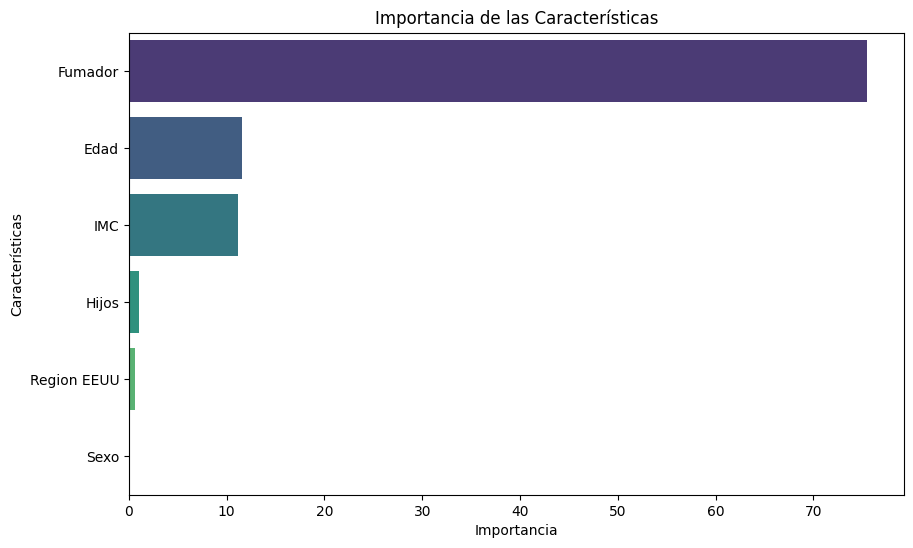

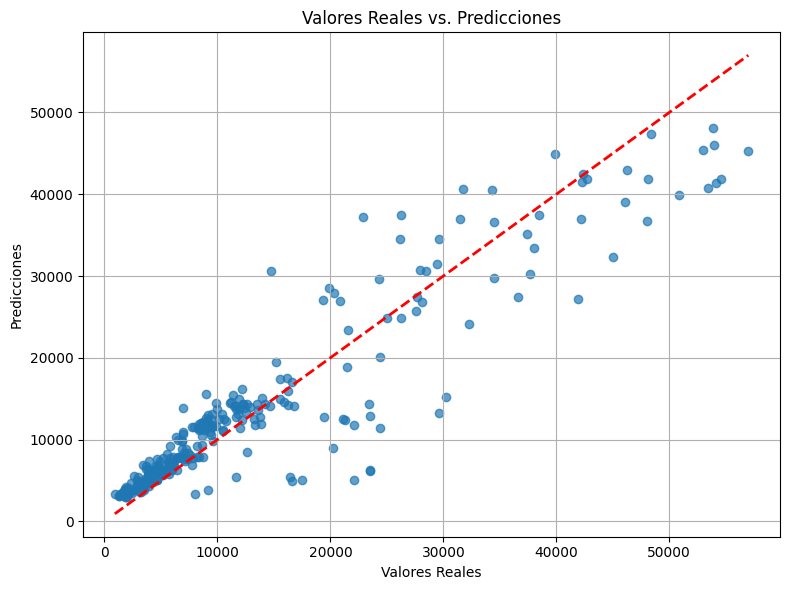

MAE: 3310.7432928778007
MSE: 24332160.979149435
RMSE: 4932.764030353514
R2 Score: 0.8563171451642749
RMSLE: 0.4101262186745642
MAPE: 35.061008434507265


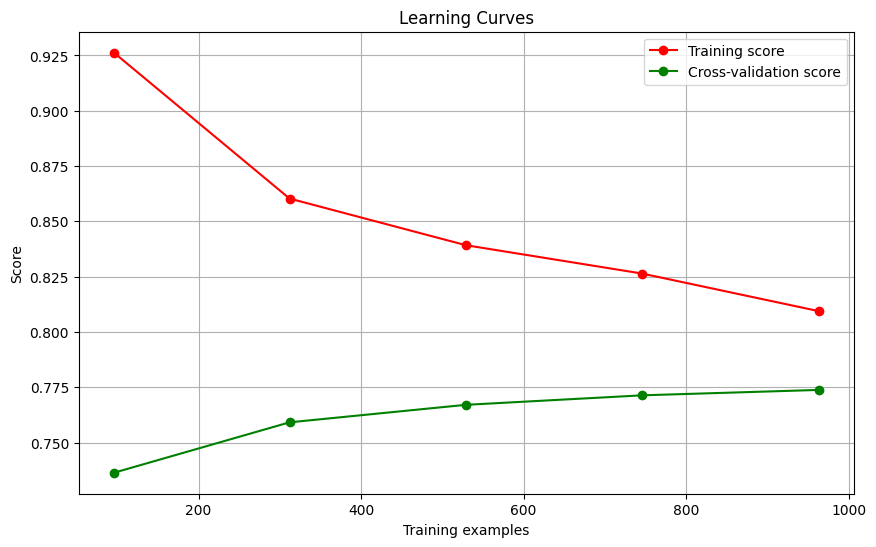

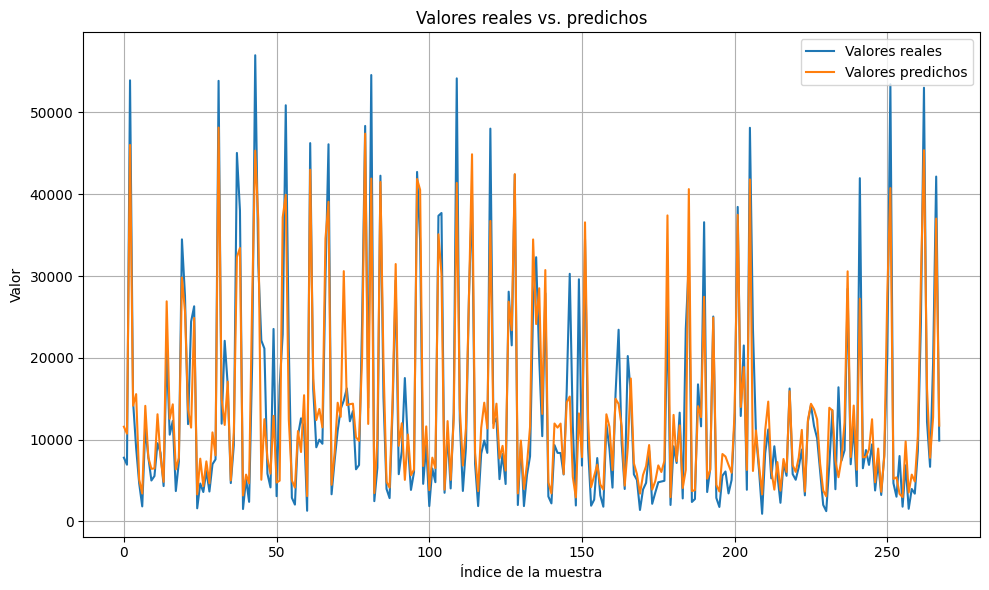

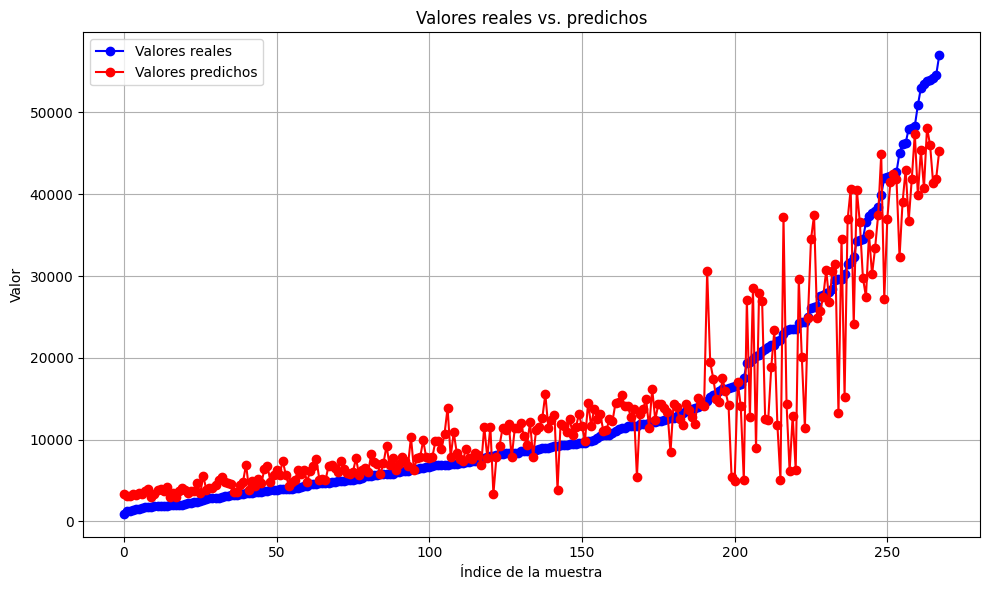

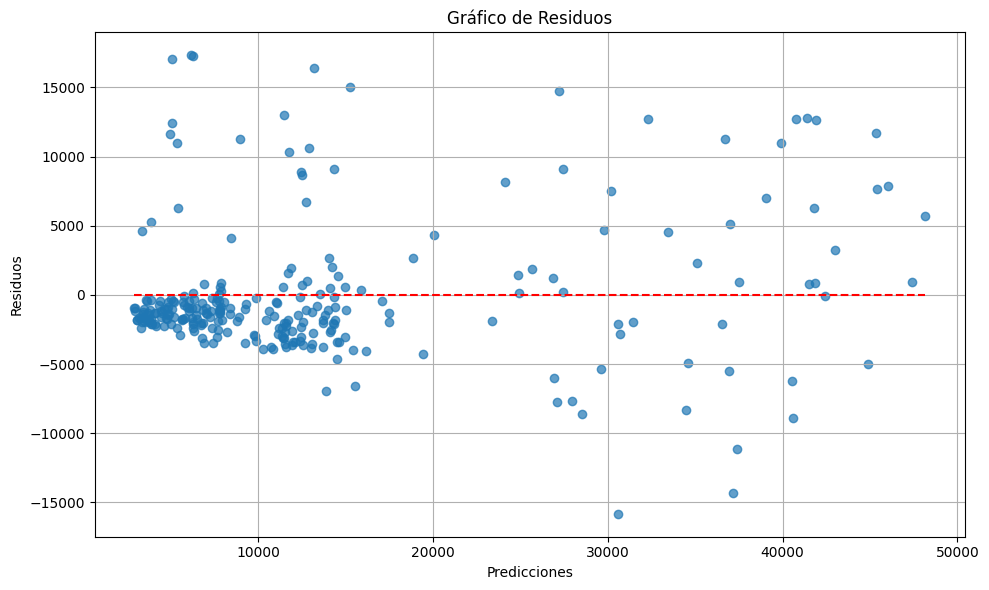

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns

# Función para cargar divisiones de datos
def load_split(seed):
    X_train = pd.read_csv(f'X_train_{seed}.csv')
    X_test = pd.read_csv(f'X_test_{seed}.csv')
    y_train = pd.read_csv(f'y_train_{seed}.csv')
    y_test = pd.read_csv(f'y_test_{seed}.csv')
    return X_train, X_test, y_train, y_test

# Cargar una división específica (por ejemplo, la primera división)
X_train, X_test, y_train, y_test = load_split(0)

# Codificar las variables categóricas después de cargar la división
le = LabelEncoder()

for column in ['Sexo', 'Fumador', 'Region EEUU']:
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])

# Convertir y_train e y_test a series de pandas para asegurar que no haya problemas de tipo
y_train = y_train.squeeze().astype(float)
y_test = y_test.squeeze().astype(float)

# Convertir y_test a array de NumPy para asegurar la compatibilidad de tipos
y_test = np.array(y_test)

# CatBoost Regression
# Iniciar el modelo
model = CatBoostRegressor(random_state=42, silent=True)

# Ajustar el modelo a los datos
model.fit(X_train, y_train)

# Realizar la validación cruzada con 10-fold
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(f"Cross-validated MSE: {-np.mean(scores)}")

# Optimización de los Hiperparámetros
# Definir los valores para iterar y elegir los mejores parámetros
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 4, 5]
}

# Iniciar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)

# Ajustar a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Actualizar el modelo con los parámetros encontrados
model = grid_search.best_estimator_

# Características más importantes
# Obtener la importancia de cada variable
importances = model.feature_importances_

# Crear un conjunto de datos para las características y su importancia
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Ordenar por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleccionar la misma paleta de colores utilizada anteriormente
n_colores = len(feature_importances)
colores = sns.color_palette('viridis', n_colors=n_colores)

# Graficar las características y su importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Realizar las predicciones
y_pred = model.predict(X_test)

# Asegurarnos de que y_test y y_pred sean del tipo float
y_test = y_test.astype(float)
y_pred = y_pred.astype(float)

# Gráfico de dispersión de los valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculamos MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Calculamos RMSLE (Root Mean Squared Logarithmic Error)
if (y_test >= 0).all() and (y_pred >= 0).all():
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print("RMSLE:", rmsle)
else:
    print("RMSLE: cannot be calculated because some values are negative")

# Calculamos MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = mape(y_test, y_pred)
print("MAPE:", mape_score)

# Graficamos la curva de aprendizaje (learning curve)
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Gráfico de línea de los valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores reales")
plt.plot(y_pred, label="Valores predichos")
plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Valores reales vs. predichos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Crear un array con el índice de las muestras
indices = np.arange(len(y_test))

# Ordenar los valores reales y predichos por los valores reales
sorted_indices = np.argsort(y_test)

# Graficar los valores reales y predichos
plt.figure(figsize=(10, 6))
plt.plot(indices, y_test[sorted_indices], 'b-', marker='o', label='Valores reales')
plt.plot(indices, y_pred[sorted_indices], 'r-', marker='o', label='Valores predichos')
plt.xlabel('Índice de la muestra')
plt.ylabel('Valor')
plt.title('Valores reales vs. predichos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficar los residuos (errores)
residuos = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.hlines(0, min(y_pred), max(y_pred), colors='red', linestyles='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(True)
plt.tight_layout()
plt.show()
